In [1]:
from datasets import load_dataset, Dataset, concatenate_datasets
from config.train_sft_model import DatasetConfig


def load_datasets(cfg: DatasetConfig, seed: int) -> Dataset:
    """
    Load training and validation datasets based on the configuration.
    Args:
        cfg (DatasetConfig): Configuration containing dataset information.
        seed (int): Random seed for reproducibility.
    Returns:
        Tuple[Dataset, Dataset]: A tuple containing the training and validation datasets.
        
    If no datasets are provided or an error occurs, returns None for the respective dataset.
    """
    train_datasets, val_datasets = [], []

    try:
        for dataset in cfg.train_datasets:
            dataset = load_dataset(dataset.name_or_path, split=dataset.split)
            train_datasets.append(dataset)

        # We sample based on max_examples and ratios.
        if cfg.max_train_examples is not None:
            ratios = [dataset.ratio for dataset in cfg.train_datasets]
            total_ratio = sum(ratios)
            num_samples = cfg.max_train_examples

            # Sample based on ratios
            if num_samples == -1:
                for i, dataset in enumerate(train_datasets):
                    train_datasets[i] = dataset.shuffle(seed=seed)
            else:
                samples_per_dataset = [
                    int(num_samples * ratio / total_ratio) for ratio in ratios
                ]
                for i, dataset in enumerate(train_datasets):
                    train_datasets[i] = dataset.shuffle(seed=seed).select(
                        range(samples_per_dataset[i])
                    )
        # Concatenate the datasets
        train_datasets = concatenate_datasets(train_datasets)
        train_datasets = train_datasets.shuffle(seed=seed)
    except Exception as e:
        train_datasets = None
        print("No training datasets provided or an error occurred while loading them.")
        print(e)

    try:
        for dataset in cfg.eval_datasets:
            dataset = load_dataset(dataset.name_or_path, split=dataset.split)
            val_datasets.append(dataset)

        if len(val_datasets) == 0:
            return train_datasets, None

        if cfg.max_val_examples is not None:
            ratios = [dataset.ratio for dataset in cfg.eval_datasets]
            total_ratio = sum(ratios)
            num_samples = cfg.max_val_examples

            # Sample based on ratios
            if num_samples == -1:
                for i, dataset in enumerate(val_datasets):
                    val_datasets[i] = dataset.shuffle(seed=seed)
            else:
                samples_per_dataset = [
                    int(num_samples * ratio / total_ratio) for ratio in ratios
                ]
                for i, dataset in enumerate(val_datasets):
                    val_datasets[i] = dataset.shuffle(seed=seed).select(
                        range(samples_per_dataset[i])
                    )

        val_datasets = concatenate_datasets(val_datasets)
        val_datasets = val_datasets.shuffle(seed=seed)
    except Exception as e:
        val_datasets = None
        print(
            "No validation datasets provided or an error occurred while loading them."
        )
        print(e)

    return train_datasets, val_datasets


In [2]:
from dataclasses import dataclass, field
from typing import Any, Dict, Optional

@dataclass
class Dataset:
    name_or_path: str = "rd211/Big-Math-RL-Verified-Filtered"
    split: str = "train"
    ratio: float = 1.0


@dataclass
class DatasetConfig:
    train_datasets: list[Dataset] = field(default_factory=lambda: [Dataset()])
    max_train_examples: int = -1

In [3]:
data_config = DatasetConfig()

In [4]:
train_dataset, _ = load_datasets(data_config, 42)

No validation datasets provided or an error occurred while loading them.
'DatasetConfig' object has no attribute 'eval_datasets'


In [13]:
train_dataset = train_dataset.filter(lambda x: x["llama8b_solve_rate"] >= 0.3)

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [14]:
train_dataset

Dataset({
    features: ['problem', 'answer', 'source', 'domain', 'llama8b_solve_rate'],
    num_rows: 3149
})

In [9]:
train_df = train_dataset.to_pandas()

In [10]:
train_df.columns

Index(['problem', 'answer', 'source', 'domain', 'llama8b_solve_rate'], dtype='object')

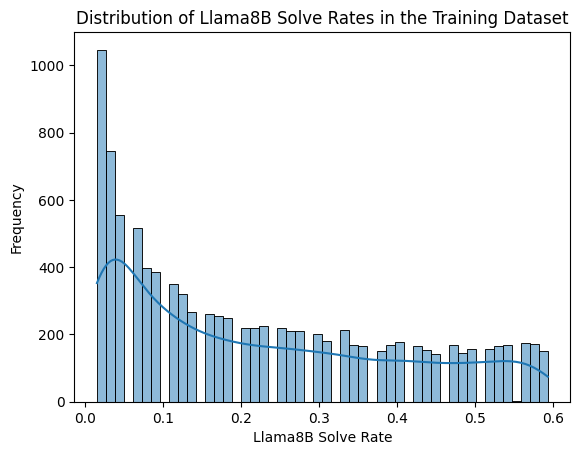

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(train_df["llama8b_solve_rate"], bins=50, kde=True)
plt.title("Distribution of Llama8B Solve Rates in the Training Dataset")
plt.xlabel("Llama8B Solve Rate")
plt.ylabel("Frequency")
plt.show()

In [12]:
len(train_df.loc[train_df["llama8b_solve_rate"] >= 0.3])

3149